Using device: cpu

=== RUNNING HONEST MAJORITY SCENARIO (Trimmed Mean) ===
Loading dataset from C:\Users\Administrator\Desktop\v2g dataset kaggle.csv...
Dataset loaded with 1000 records
Columns: participant_id, timestamp, battery_capacity_kWh, current_charge_kWh, discharge_rate_kW, energy_requested_kWh, label
Label classes: adversarial, honest
Data distribution: 539 honest, 231 adversarial records
Participant distribution: 539 honest, 231 adversarial participants
Applying deterministic data augmentation...
Features: 11, Classes: 2
Dataset participant IDs: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75

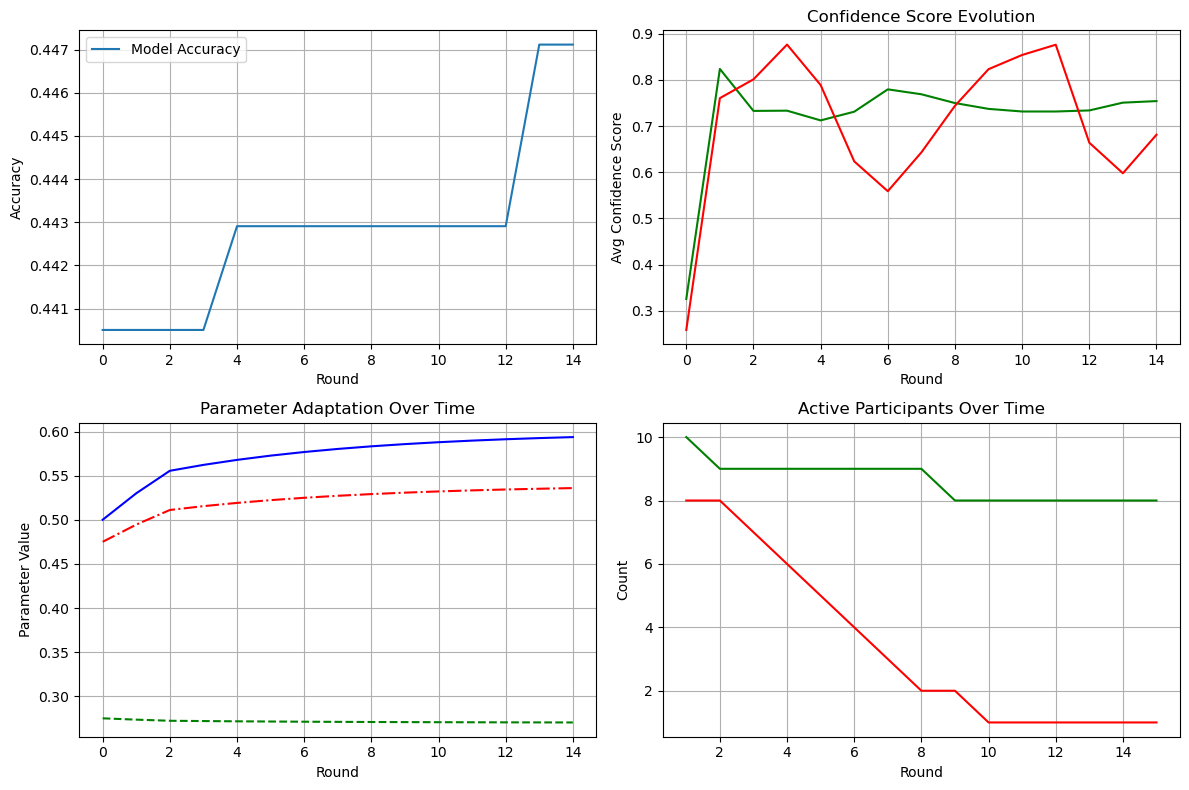

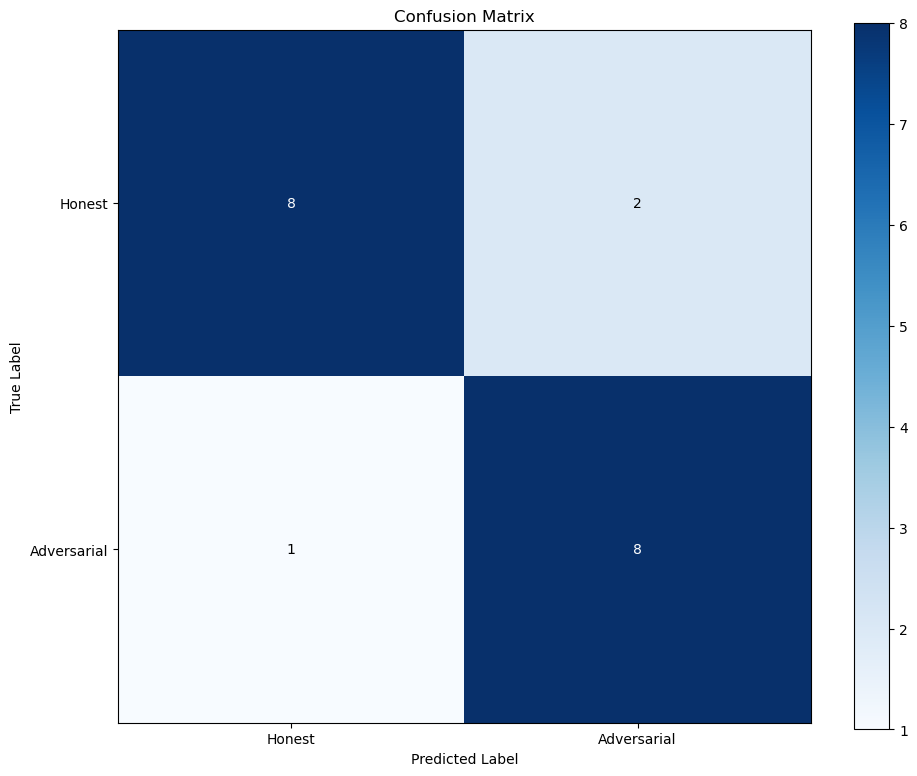


DETECTION PERFORMANCE:
--------------------------------------------------
Accuracy: 84.21%
Precision: 80.00%
Recall: 88.89%
F1 Score: 84.21%
--------------------------------------------------
Honest Removed: 20.0% (2/10)
Adversarial Removed: 88.9% (8/9)
Removal Preference: 4.4x
--------------------------------------------------
True Positives: 8
False Positives: 2
True Negatives: 8
False Negatives: 1
--------------------------------------------------
Parameter Adaptation:
 Final Detection Ratio: 0.59
 Removal Threshold Change: -0.00
 Confidence Threshold Change: 0.06
--------------------------------------------------

PARTICIPANT BEHAVIOR ANALYSIS:
--------------------------------------------------
Average selection rate (honest): 0.307
Average selection rate (adversarial): 0.304
Selection rate gap: 0.003

FINAL RESULTS:
Honest participants: 8/10 remaining (20.0% removed)
Adversarial participants: 1/9 remaining (88.9% removed)
Removal preference ratio: 4.4x

Simulation completed!
Tota

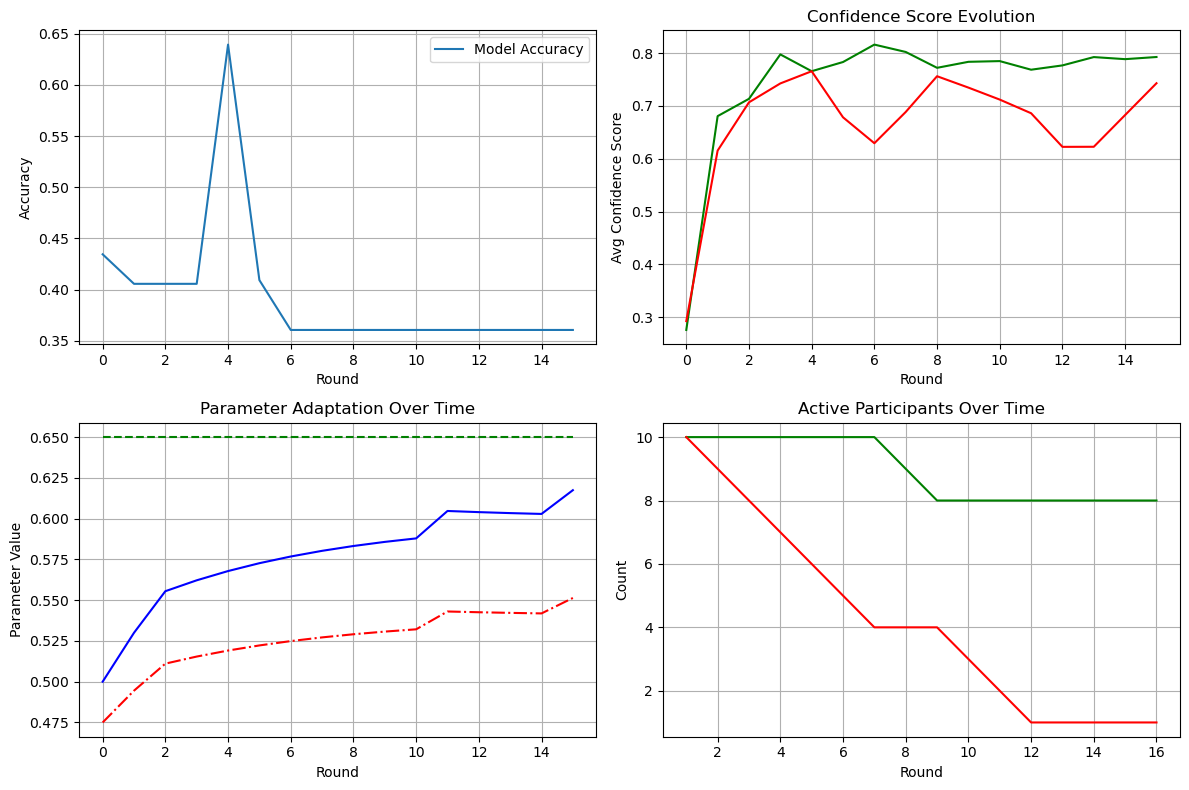

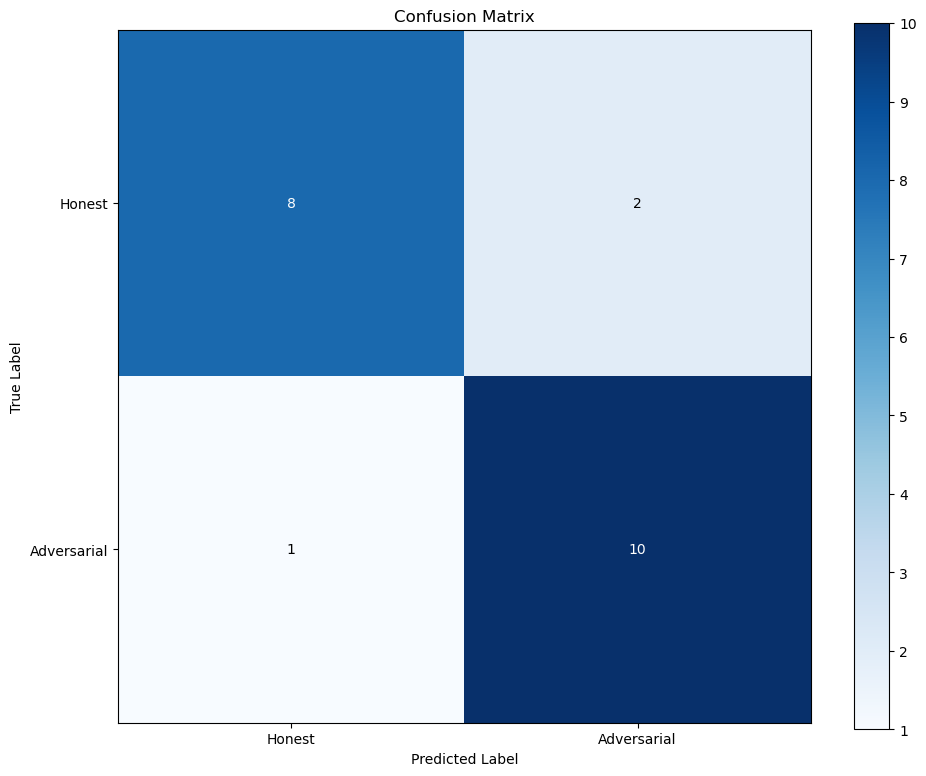


DETECTION PERFORMANCE:
--------------------------------------------------
Accuracy: 85.71%
Precision: 83.33%
Recall: 90.91%
F1 Score: 86.96%
--------------------------------------------------
Honest Removed: 20.0% (2/10)
Adversarial Removed: 90.9% (10/11)
Removal Preference: 4.5x
--------------------------------------------------
True Positives: 10
False Positives: 2
True Negatives: 8
False Negatives: 1
--------------------------------------------------
Parameter Adaptation:
 Final Detection Ratio: 0.62
 Removal Threshold Change: 0.00
 Confidence Threshold Change: 0.08
--------------------------------------------------

PARTICIPANT BEHAVIOR ANALYSIS:
--------------------------------------------------
Average selection rate (honest): 0.319
Average selection rate (adversarial): 0.286
Selection rate gap: 0.033

FINAL RESULTS:
Honest participants: 8/10 remaining (20.0% removed)
Adversarial participants: 1/11 remaining (90.9% removed)
Removal preference ratio: 4.5x

Simulation completed!
T

In [27]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from torch.utils.data import Dataset, DataLoader, Subset
from imblearn.over_sampling import SMOTE
import random
from collections import defaultdict, deque
import matplotlib.pyplot as plt
import os
from tsaug import AddNoise, TimeWarp
import warnings
from datetime import datetime, timedelta
import requests
import zipfile

warnings.filterwarnings('ignore')

def set_full_determinism():
    """Set all random seeds for complete reproducibility"""
    random.seed(42)
    np.random.seed(42)
    torch.manual_seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(42)
        torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = '42'
    
    # Set for DataLoader workers
    def seed_worker(worker_id):
        worker_seed = torch.initial_seed() % 2**32
        np.random.seed(worker_seed)
        random.seed(worker_seed)
    
    g = torch.Generator()
    g.manual_seed(42)
    return g, seed_worker

# Set full determinism
data_loader_generator, seed_worker_fn = set_full_determinism()

# Device configuration
device = torch.device('cpu')

# -----------------------------
# Custom Focal Loss
# -----------------------------
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.98, gamma=4.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
    def forward(self, outputs, targets):
        nll_loss = nn.NLLLoss(reduction='none')(outputs, targets)
        pt = torch.exp(-nll_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * nll_loss
        return focal_loss.mean()

# -----------------------------
# Dataset with deterministic augmentation
# -----------------------------
class V2GDataset(Dataset):
    def __init__(self, csv_path):
        # Set seed for dataset operations
        dataset_rng = random.Random(42)
        np_rng = np.random.RandomState(42)
        
        self.data = pd.read_csv(csv_path)
        print(f"Dataset loaded with {len(self.data)} records")
        print(f"Columns: {', '.join(self.data.columns)}")

        # Timestamp features
        if 'timestamp' in self.data.columns:
            self.data['timestamp'] = pd.to_datetime(self.data['timestamp'])
            self.data['hour'] = self.data['timestamp'].dt.hour
            self.data['day_of_week'] = self.data['timestamp'].dt.dayofweek
            self.data['is_weekend'] = (self.data['day_of_week'] >= 5).astype(int)
        else:
            self.data['hour'] = 0
            self.data['day_of_week'] = 0
            self.data['is_weekend'] = 0

        # Feature engineering
        eps = 1e-6
        self.data['charge_discharge_ratio'] = self.data['current_charge_kWh'] / (self.data['discharge_rate_kW'] + eps)
        self.data['energy_hour_interaction'] = self.data['energy_requested_kWh'] * self.data['hour']
        self.data['charge_capacity_ratio'] = self.data['current_charge_kWh'] / (self.data['battery_capacity_kWh'] + eps)
        self.data['efficiency_estimate'] = self.data['energy_requested_kWh'] / (self.data['discharge_rate_kW'] * 0.25 + eps)

        # Labels
        if 'label' not in self.data.columns:
            raise ValueError("Dataset must contain a 'label' column")
        self.data['label'] = self.data['label'].astype(str).str.lower()
        valid_labels = ['honest', 'adversarial']
        self.data = self.data[self.data['label'].isin(valid_labels)]
        if self.data.empty:
            raise ValueError("No valid labels found in dataset. Expected 'honest' or 'adversarial'.")

        initial_len = len(self.data)
        self.data = self.data.dropna(subset=['label'])
        if len(self.data) < initial_len:
            print(f"Removed {initial_len - len(self.data)} rows with missing labels")

        # Required fields
        if 'participant_id' not in self.data.columns:
            raise ValueError("Dataset must contain a 'participant_id' column")

        # Features
        feature_cols = [
            'battery_capacity_kWh', 'current_charge_kWh', 'discharge_rate_kW',
            'energy_requested_kWh', 'hour', 'charge_discharge_ratio',
            'energy_hour_interaction', 'charge_capacity_ratio',
            'efficiency_estimate', 'day_of_week', 'is_weekend'
        ]
        for col in feature_cols:
            if col not in self.data.columns:
                raise ValueError(f"Missing feature column: {col}")

        self.features = self.data[feature_cols].values
        self.labels = self.data['label'].values
        self.participant_ids = self.data['participant_id'].values
        self.original_indices = np.arange(len(self.data))

        # Pre-SMOTE stats
        self.label_encoder = LabelEncoder()
        original_labels = self.label_encoder.fit_transform(self.labels)
        print(f"Label classes: {', '.join(str(cls) for cls in self.label_encoder.classes_)}")

        unique_participants = len(set(self.participant_ids))
        honest_count = sum(original_labels == self.label_encoder.transform(['honest'])[0])
        adversarial_count = len(original_labels) - honest_count
        print(f"Data distribution: {honest_count} honest, {adversarial_count} adversarial records")

        honest_mask = original_labels == self.label_encoder.transform(['honest'])[0]
        honest_parts = len(set(self.participant_ids[honest_mask]))
        adversarial_parts = unique_participants - honest_parts
        print(f"Participant distribution: {honest_parts} honest, {adversarial_parts} adversarial participants")

        # Deterministic data augmentation without tsaug's random_state
        print("Applying deterministic data augmentation...")
        
        # Add noise manually with fixed seed
        np_rng = np.random.RandomState(42)
        X_aug = self.features.copy()
        noise = np_rng.normal(0, 0.1, size=X_aug.shape)
        X_aug = X_aug + noise
        
        # Time warp simulation - simple shifting with deterministic pattern
        for i in range(X_aug.shape[0]):
            shift_amount = (i % 3) - 1  # Deterministic pattern: -1, 0, 1, -1, 0, 1...
            if shift_amount != 0:
                X_aug[i] = np.roll(X_aug[i], shift_amount)
        
        # Deterministic scaling
        scale_factors = np_rng.uniform(0.9, 1.1, size=(X_aug.shape[0], 1))
        X_aug = X_aug * scale_factors
        
        y_aug = self.labels
        self.features = np.vstack([self.features, X_aug])
        self.labels = np.concatenate([self.labels, y_aug])
        self.participant_ids = np.concatenate([self.participant_ids, self.participant_ids])
        self.original_indices = np.concatenate([self.original_indices, self.original_indices])

        # Global SMOTE with fixed seed
        smote = SMOTE(sampling_strategy='auto', k_neighbors=3, random_state=42)
        self.features, self.labels = smote.fit_resample(self.features, self.labels)
        self.labels = self.label_encoder.transform(self.labels)

        # Ensure minimum 10 records per participant with deterministic sampling
        participant_indices = {}
        for pid in np.unique(self.participant_ids):
            idx = np.where(self.participant_ids == pid)[0]
            participant_indices[pid] = idx
            if len(idx) < 10:
                unique_labels = np.unique(self.labels[idx])
                if len(unique_labels) > 1:
                    extra_samples, extra_labels = smote.fit_resample(self.features[idx], self.labels[idx])
                    extra_samples = extra_samples[:10 - len(idx)]
                    extra_labels = extra_labels[:10 - len(idx)]
                else:
                    num_needed = 10 - len(idx)
                    # Deterministic sampling based on participant ID
                    participant_rng = np.random.RandomState(42 + int(pid))
                    indices_to_duplicate = participant_rng.choice(idx, size=num_needed, replace=True)
                    extra_samples = self.features[indices_to_duplicate]
                    extra_labels = self.labels[indices_to_duplicate]

                self.features = np.vstack([self.features, extra_samples])
                self.labels = np.concatenate([self.labels, extra_labels])
                self.participant_ids = np.concatenate([self.participant_ids, [pid] * len(extra_samples)])
                self.original_indices = np.concatenate([self.original_indices, [self.original_indices[idx[0]]] * len(extra_samples)])

        # Scale
        self.scaler = StandardScaler()
        self.features = self.scaler.fit_transform(self.features)

        # Stats
        self.num_features = self.features.shape[1]
        self.num_classes = len(self.label_encoder.classes_)
        print(f"Features: {self.num_features}, Classes: {self.num_classes}")
        print(f"Dataset participant IDs: {sorted(set(self.participant_ids))}")

        # Tensors
        self.features = torch.tensor(self.features, dtype=torch.float32)
        self.labels = torch.tensor(self.labels, dtype=torch.long)

        # Group indices by participant
        self.participant_indices = defaultdict(list)
        for idx, pid in enumerate(self.participant_ids):
            self.participant_indices[pid].append(idx)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

    def get_participant_data(self, participant_id):
        indices = self.participant_indices.get(participant_id, [])
        return self.features[indices], self.labels[indices]

    def get_participant_indices(self, participant_id):
        return self.participant_indices.get(participant_id, [])

    def get_participant_type(self, participant_id):
        indices = self.get_participant_indices(participant_id)
        if not indices:
            return None
        labels = self.labels[indices].numpy()
        return 'honest' if np.mean(labels == self.label_encoder.transform(['honest'])[0]) > 0.5 else 'adversarial'

    def get_original_indices(self):
        return self.original_indices

# -----------------------------
# Model (unchanged)
# -----------------------------
class V2GClassifier(nn.Module):
    def __init__(self, input_size, hidden_size=512, num_classes=2, dropout=0.35):
        super(V2GClassifier, self).__init__()
        # Initialize weights with fixed seed
        torch.manual_seed(42)
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.norm1 = nn.LayerNorm(hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.hidden_layer1 = nn.Linear(hidden_size, hidden_size // 2)
        self.norm2 = nn.LayerNorm(hidden_size // 2)
        self.hidden_layer2 = nn.Linear(hidden_size // 2, hidden_size // 4)
        self.norm3 = nn.LayerNorm(hidden_size // 4)
        self.output_layer = nn.Linear(hidden_size // 4, num_classes)
        self.log_softmax = nn.LogSoftmax(dim=1)
        
        # Initialize weights deterministically
        self._reset_parameters()
        
    def _reset_parameters(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)
                    
    def forward(self, x):
        x = self.input_layer(x)
        x = self.norm1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.hidden_layer1(x)
        x = self.norm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.hidden_layer2(x)
        x = self.norm3(x)
        x = self.relu(x)
        x = self.output_layer(x)
        return self.log_softmax(x)

# -----------------------------
# Adaptive Parameters (unchanged)
# -----------------------------
class AdaptiveParameters:
    def __init__(self, num_honest, num_adversarial, adaptive_mode=True):
        self.num_honest = num_honest
        self.num_adversarial = num_adversarial
        self.adversarial_majority = num_adversarial > num_honest
        self.adaptive_mode = adaptive_mode
        self.current_detected_ratio = 0.5
        self.init_parameters()

    def init_parameters(self):
        self.num_byzantines = 15
        total_participants = self.num_honest + self.num_adversarial
        self.multi_krum_m = 30  # kept for reference; not used by Trimmed Mean
        # base thresholds
        self.removal_threshold_base = 0.30 if not self.adversarial_majority else 0.65
        self.max_removal_rate_base = 0.60 if not self.adversarial_majority else 0.45
        self.min_removal_threshold_base = 0.15 if not self.adversarial_majority else 0.65
        self.bootstrap_rounds_base = 4 if not self.adversarial_majority else 3
        self.whitelist_rounds_base = 5 if not self.adversarial_majority else 30
        self.confidence_threshold_base = 0.15
        self.reputation_decay_base = 0.95 if not self.adversarial_majority else 0.90
        self.honest_protection_factor_base = 4.0 if not self.adversarial_majority else 10.0
        self.forced_removal_base = True
        self.min_accuracy_threshold_base = 0.50
        self.adv_per_round_limit_base = 5
        self.patience_base = 10
        self.min_rounds_base = 10
        self.suspicion_weight_base = 0.45
        self.selection_factor_weight_base = 0.40
        self.behavior_factor_weight_base = 0.20
        self.consecutive_factor_weight_base = 0.05
        self.reputation_factor_weight_base = 0.10
        # adversarial scenario variants
        self.removal_threshold_adv = 0.25
        self.max_removal_rate_adv = 0.80
        self.min_removal_threshold_adv = 0.20
        self.bootstrap_rounds_adv = 1
        self.whitelist_rounds_adv =15
        self.confidence_threshold_adv = 0.8
        self.reputation_decay_adv = 0.90
        self.honest_protection_factor_adv = 10.0
        self.forced_removal_adv = True
        self.min_accuracy_threshold_adv = 0.40
        self.adv_per_round_limit_adv = 15
        self.patience_adv = 8
        self.min_rounds_adv = 20
        self.suspicion_weight_adv = 0.35
        self.selection_factor_weight_adv = 0.40
        self.behavior_factor_weight_adv = 0.15
        self.consecutive_factor_weight_adv = 0.00
        self.reputation_factor_weight_adv = 0.00

        self.honest_removal_budget = max(2, int(round(self.num_honest * 0.25)))
        self.safe_list_selection_threshold = 0.4
        self.safe_list_reputation_threshold = 0.65
        self.gradient_cv_threshold = 0.55
        self.behavioral_flag_threshold = 1.9
        self.reputation_penalty = 0.18
        self.min_selection_rate = 0.01
        self.honest_selection_rate_threshold = 0.48
        self.honest_reputation_threshold = 0.88
        self.honest_gradient_cv_threshold = 0.22
        self.honest_accuracy_threshold = 0.58
        self.update_factor = 0.15
        self.max_adaptation = 0.85
        # Trimmed Mean parameters
        self.trimming_fraction = 0.55  # 20% trimmed on each side
        self.participation_fraction = 0.4  # fraction of active participants to include each round
        self.update_parameters(self.adversarial_majority)

    def update_parameters(self, adversarial_focus):
        if isinstance(adversarial_focus, bool):
            adv_ratio = 1.0 if adversarial_focus else 0.0
        else:
            adv_ratio = min(max(adversarial_focus, 0.0), 1.0)

        self.removal_threshold = max(self.removal_threshold_base + adv_ratio * (self.removal_threshold_adv - self.removal_threshold_base), self.min_removal_threshold_base)
        self.max_removal_rate = self.max_removal_rate_base + adv_ratio * (self.max_removal_rate_adv - self.max_removal_rate_base)
        self.bootstrap_rounds = int(self.bootstrap_rounds_base + adv_ratio * (self.bootstrap_rounds_adv - self.bootstrap_rounds_base))
        self.whitelist_rounds = int(self.whitelist_rounds_base + adv_ratio * (self.whitelist_rounds_adv - self.whitelist_rounds_base))
        self.confidence_threshold = self.confidence_threshold_base + adv_ratio * (self.confidence_threshold_adv - self.confidence_threshold_base)
        self.reputation_decay = self.reputation_decay_base + adv_ratio * (self.reputation_decay_adv - self.reputation_decay_base)
        self.honest_protection_factor = self.honest_protection_factor_base + adv_ratio * (self.honest_protection_factor_adv - self.honest_protection_factor_base)
        self.forced_removal = True if adv_ratio > 0.3 else self.forced_removal_base
        self.min_accuracy_threshold = self.min_accuracy_threshold_base + adv_ratio * (self.min_accuracy_threshold_adv - self.min_accuracy_threshold_base)
        self.adv_per_round_limit = int(self.adv_per_round_limit_base + adv_ratio * (self.adv_per_round_limit_adv - self.adv_per_round_limit_base))
        self.patience = int(self.patience_base + adv_ratio * (self.patience_adv - self.patience_base))
        self.min_rounds = int(self.min_rounds_base + adv_ratio * (self.min_rounds_adv - self.min_rounds_base))
        self.suspicion_weight = self.suspicion_weight_base + adv_ratio * (self.suspicion_weight_adv - self.suspicion_weight_base)
        self.selection_factor_weight = self.selection_factor_weight_base + adv_ratio * (self.selection_factor_weight_adv - self.selection_factor_weight_base)
        self.behavior_factor_weight = self.behavior_factor_weight_base + adv_ratio * (self.behavior_factor_weight_adv - self.behavior_factor_weight_base)
        self.consecutive_factor_weight = self.consecutive_factor_weight_base + adv_ratio * (self.consecutive_factor_weight_adv - self.consecutive_factor_weight_base)
        self.reputation_factor_weight = self.reputation_factor_weight_base + adv_ratio * (self.reputation_factor_weight_adv - self.reputation_factor_weight_base)

    def adapt_to_environment(self, metric_data):
        if not self.adaptive_mode:
            return
        avg_grad_cv = metric_data.get('avg_gradient_cv', 0.5)
        selection_variance = metric_data.get('selection_variance', 0.5)
        recent_accuracy = metric_data.get('recent_accuracy', 0.6)
        confidence_disparity = metric_data.get('confidence_disparity', 0.5)

        environment_assessment = (
            (avg_grad_cv > 0.30) * 0.40 +
            (selection_variance > 0.20) * 0.30 +
            (recent_accuracy < 0.55) * 0.20 +
            (confidence_disparity > 0.20) * 0.10
        )

        self.current_detected_ratio = (1 - self.update_factor) * self.current_detected_ratio + self.update_factor * environment_assessment
        mid_point = 0.5
        if self.adversarial_majority:
            self.current_detected_ratio = max(mid_point, min(1.0, self.current_detected_ratio))
        else:
            self.current_detected_ratio = min(max(0.0, self.current_detected_ratio), mid_point + self.max_adaptation)

        self.update_parameters(self.current_detected_ratio)

    def get_status(self):
        return {
            "detected_ratio": self.current_detected_ratio,
            "removal_threshold": self.removal_threshold,
            "confidence_threshold": self.confidence_threshold,
            "max_removal_rate": self.max_removal_rate,
            "forced_removal": self.forced_removal,
            "behavior_weight": self.behavior_factor_weight,
            "selection_weight": self.selection_factor_weight
        }

# -----------------------------
# Server with Trimmed Mean (unchanged)
# -----------------------------
class ImprovedFederatedServer:
    def __init__(self, model, num_honest, num_adversarial, device='cpu', dataset=None, adaptive_mode=True):
        self.model = model.to(device)
        self.device = device
        self.num_honest = num_honest
        self.num_adversarial = num_adversarial
        self.dataset = dataset
        self.current_round = 0
        self.best_accuracy = 0.0
        self.rounds_without_improvement = 0
        self.participants = {}
        self.reputation_scores = {}
        self.confidence_scores = {}
        self.gradient_norms = defaultdict(list)
        self.gradient_directions = defaultdict(list)
        self.selection_history = defaultdict(list)
        self.accuracy_history = []
        self.removed_participants = []
        self.safe_list = set()
        self.honest_removed_count = 0
        self.selection_rates = defaultdict(float)
        self.gradient_cvs = defaultdict(float)
        self.confidence_history = defaultdict(list)
        self.suspicious_patterns = defaultdict(int)
        self.accuracy_improvements = []
        self.parameter_history = []
        self.gradient_cosine_similarities = defaultdict(list)
        self.gradient_deviations = defaultdict(float)
        self.participation_consistency = defaultdict(float)
        self.historical_suspicion = defaultdict(list)
        self.last_selected_round = defaultdict(int)
        self.params = AdaptiveParameters(num_honest, num_adversarial, adaptive_mode)

        print(f"{'ADVERSARIAL MAJORITY DETECTED' if self.params.adversarial_majority else 'HONEST MAJORITY DETECTED'} - Using {'adaptive' if adaptive_mode else 'fixed'} strategy")
        print(f"Detection params: threshold={self.params.removal_threshold:.2f}, rate={self.params.max_removal_rate:.2f}")
        print(f"Honest protection: budget={self.params.honest_removal_budget}, factor={self.params.honest_protection_factor:.2f}")

        self._initialize_participants(dataset)

    def _initialize_participants(self, dataset):
        available_pids = list(set(dataset.participant_ids))
        if len(available_pids) < self.num_honest + self.num_adversarial:
            print(f"Warning: Only {len(available_pids)} participants available, adjusting counts")
            total = self.num_honest + self.num_adversarial
            self.num_honest = int(len(available_pids) * (self.num_honest / total))
            self.num_adversarial = len(available_pids) - self.num_honest
            print(f"Adjusted to {self.num_honest} honest and {self.num_adversarial} adversarial participants")

        # Deterministic shuffling
        rng = random.Random(42)
        available_pids_sorted = sorted(available_pids)
        rng.shuffle(available_pids_sorted)
        honest_ids = available_pids_sorted[:self.num_honest]
        adversarial_ids = available_pids_sorted[self.num_honest:self.num_honest + self.num_adversarial]

        def _new_participant(pid):
            # Set seed for model initialization based on participant ID
            torch.manual_seed(42 + pid)
            model = V2GClassifier(self.model.input_layer.in_features, num_classes=self.model.output_layer.out_features).to(self.device)
            
            return {
                'model': model,
                'type': None,
                'data': None,
                'active': True,
                'suspicion_score': 0.0,
                'behavioral_flags': 0.0,
                'selection_count': 0,
                'gradient_history': deque(maxlen=5),
                'accuracy_history': deque(maxlen=10),
                'detected_anomalies': 0,
                'participation_rate': 1.0,
                'consistent_behavior_score': 1.0,
                'rounds_since_selection': 0
            }

        for idx in honest_ids:
            p = _new_participant(idx)
            p['type'] = 'honest'
            self.participants[idx] = p
            self.reputation_scores[idx] = 1.0
            self.confidence_scores[idx] = 0.0

        for idx in adversarial_ids:
            p = _new_participant(idx)
            p['type'] = 'adversarial'
            self.participants[idx] = p
            self.reputation_scores[idx] = 1.0
            self.confidence_scores[idx] = 0.0

        print(f"Server initialized with {self.num_honest} honest and {self.num_adversarial} adversarial participants")

    def deterministic_selection(self, active_ids, k, reputations, round_idx):
        """Deterministic participant selection based on round index"""
        rng = np.random.RandomState(42 + round_idx)
        probs = np.array([reputations.get(idx, 1.0) for idx in active_ids], dtype=float)
        probs = probs + 1e-6
        probs = probs / probs.sum()
        return list(rng.choice(active_ids, size=min(k, len(active_ids)), replace=False, p=probs))

    # -------- Gradient metrics --------
    def calculate_gradient_metrics(self, idx, gradients):
        grad_vector = torch.cat([g.flatten() for g in gradients]).to(self.device)
        norm = torch.norm(grad_vector).item()
        self.gradient_norms[idx].append(norm)

        # CV
        norms = self.gradient_norms[idx][-10:] if len(self.gradient_norms[idx]) >= 10 else self.gradient_norms[idx]
        if len(norms) < 5:
            variance = np.var(norms)
            mean_norm = np.mean(norms)
            cv = np.sqrt(variance) / (mean_norm + 1e-10)
            self.gradient_cvs[idx] = cv
            if cv > self.params.gradient_cv_threshold:
                self.participants[idx]['behavioral_flags'] += 4.0
                self.suspicious_patterns[idx] += 2.0
            elif cv > self.params.gradient_cv_threshold * 0.7:
                self.participants[idx]['behavioral_flags'] += 0.8
                self.suspicious_patterns[idx] += 0.8

        # Direction change
        if len(self.gradient_directions[idx]) >= 1:
            prev_grad = torch.cat([g.flatten() for g in self.gradient_directions[idx][-1]]).to(self.device)
            direction_change = torch.dot(grad_vector / (norm + 1e-10), prev_grad / (torch.norm(prev_grad) + 1e-10)).item()
            self.gradient_cosine_similarities[idx].append(direction_change)
            magnitude_diff = abs(norm - torch.norm(prev_grad).item()) / (torch.norm(prev_grad).item() + 1e-10)

            if direction_change < 0.1:
                self.participants[idx]['behavioral_flags'] += 25.0
                self.suspicious_patterns[idx] += 10.0
                self.participants[idx]['suspicion_score'] += 0.5
            elif direction_change < 0.1:
                self.participants[idx]['behavioral_flags'] += 5.0
                self.suspicious_patterns[idx] += 5.0
                self.participants[idx]['suspicion_score'] += 0.3
            elif direction_change > 0.98:
                self.participants[idx]['behavioral_flags'] += 2.0
                self.suspicious_patterns[idx] += 2.0
                self.participants[idx]['suspicion_score'] += 0.2

            if magnitude_diff > 0.4:
                self.participants[idx]['behavioral_flags'] += 4.0
                self.suspicious_patterns[idx] += 4.0
                self.participants[idx]['suspicion_score'] += 0.25
            elif magnitude_diff > 0.2:
                self.participants[idx]['behavioral_flags'] += 2.0
                self.suspicious_patterns[idx] += 2.0
                self.participants[idx]['suspicion_score'] += 0.15

        self.participants[idx]['rounds_since_selection'] += 1
        if self.participants[idx]['rounds_since_selection'] > 3:
            self.participants[idx]['behavioral_flags'] += 0.5 * (self.participants[idx]['rounds_since_selection'] - 3)

        self.gradient_directions[idx].append([g.clone().detach() for g in gradients])

        # Deviation from average safe list gradient (if exists)
        honest_candidates = [pid for pid in self.safe_list if self.participants[pid]['active']]
        if honest_candidates and len(self.gradient_directions[idx]) > 0:
            avg_honest_grad = None
            honest_count = 0
            for hid in honest_candidates:
                if hid in self.gradient_directions and self.gradient_directions[hid]:
                    h_grad = torch.cat([g.flatten() for g in self.gradient_directions[hid][-1]]).to(self.device)
                    if avg_honest_grad is None:
                        avg_honest_grad = h_grad
                    else:
                        avg_honest_grad += h_grad
                    honest_count += 1

            if honest_count > 0 and avg_honest_grad is not None:
                avg_honest_grad = avg_honest_grad / honest_count
                cos_sim = torch.dot(grad_vector / (norm + 1e-10),
                                    avg_honest_grad / (torch.norm(avg_honest_grad) + 1e-10)).item()
                self.gradient_deviations[idx] = 1.0 - cos_sim
                if self.gradient_deviations[idx] > 0.4:
                    deviation_penalty = (self.gradient_deviations[idx] - 0.4) * 5.0
                    self.participants[idx]['behavioral_flags'] += deviation_penalty
                    self.suspicious_patterns[idx] += deviation_penalty

    # -------- Trimmed Mean Aggregation --------
    def aggregate_with_trimmed_mean(self, gradients_dict, selected_ids=None, trimming_fraction=None):
        if not gradients_dict:
            return None, []

        if trimming_fraction is None:
            trimming_fraction = self.params.trimming_fraction

        # Choose participants for this round if not supplied:
        active_ids = [idx for idx, p in self.participants.items() if p['active'] and idx in gradients_dict]
        if not active_ids:
            return None, []

        # Size of round cohort
        k = max(3, int(len(active_ids) * self.params.participation_fraction))
        
        # Use deterministic selection
        if selected_ids is None:
            reputations = {idx: self.reputation_scores.get(idx, 1.0) for idx in active_ids}
            selected_ids = self.deterministic_selection(active_ids, k, reputations, self.current_round)

        # Mark selection history and rates
        for idx in active_ids:
            was_selected = idx in selected_ids
            self.selection_history[idx].append(was_selected)
            if was_selected:
                self.participants[idx]['selection_count'] += 1
                self.participants[idx]['rounds_since_selection'] = 0
                self.last_selected_round[idx] = self.current_round
            else:
                self.participants[idx]['rounds_since_selection'] += 1
            self.selection_rates[idx] = self.participants[idx]['selection_count'] / max(1, self.current_round)

        # Prepare stacked tensors per parameter
        param_grads_per_idx = {idx: [g.clone().detach().to(self.device) for g in gradients_dict[idx]] for idx in selected_ids}

        # For each parameter tensor (by position), stack across selected participants and trimmed-mean reduce
        num_params = len(next(iter(param_grads_per_idx.values())))
        aggregated = []
        for p_i in range(num_params):
            grads = [param_grads_per_idx[idx][p_i].flatten() for idx in selected_ids]
            if len(grads) == 0:
                aggregated.append(torch.zeros_like(next(iter(param_grads_per_idx.values()))[p_i]))
                continue
            stacked = torch.stack(grads, dim=0)  # shape: [sel, D]
            sel = stacked.shape[0]
            t = int(np.floor(trimming_fraction * sel))
            if 2 * t >= sel:
                t = max(0, (sel - 1) // 2)

            # Coordinate-wise trimmed mean
            # Sort along the cohort dimension for each coordinate
            sorted_vals, _ = torch.sort(stacked, dim=0)
            trimmed = sorted_vals[t: sel - t] if sel - 2 * t > 0 else sorted_vals
            coord_mean = trimmed.mean(dim=0)

            # Reshape back to original parameter shape
            param_shape = param_grads_per_idx[selected_ids[0]][p_i].shape
            aggregated.append(coord_mean.view(param_shape))

        return aggregated, selected_ids

    # -------- Reputation, safe list, confidence --------
    def update_reputation_scores(self, selected_ids):
        for idx in self.participants:
            if not self.participants[idx]['active']:
                continue
            if idx in selected_ids:
                self.reputation_scores[idx] = min(1.0, self.reputation_scores[idx] + 0.07)
            else:
                self.reputation_scores[idx] = max(0.1, self.reputation_scores[idx] * self.params.reputation_decay)

            if self.participants[idx]['behavioral_flags'] >= self.params.behavioral_flag_threshold:
                penalty = self.params.reputation_penalty * (self.participants[idx]['behavioral_flags'] / self.params.behavioral_flag_threshold)
                self.reputation_scores[idx] = max(0.1, self.reputation_scores[idx] - penalty)
                self.participants[idx]['behavioral_flags'] = 0

            if self.current_round >= 10 and self.selection_rates[idx] < self.params.min_selection_rate:
                low_selection_penalty = 0.09 * (1.0 + (self.params.min_selection_rate - self.selection_rates[idx]) * 3)
                self.reputation_scores[idx] = max(0.1, self.reputation_scores[idx] - low_selection_penalty)

            if len(self.selection_history[idx]) >= 5:
                recent = self.selection_history[idx][-5:]
                if all(recent):
                    self.reputation_scores[idx] = min(1.0, self.reputation_scores[idx] + 0.06)
                elif not any(recent):
                    self.reputation_scores[idx] = max(0.1, self.reputation_scores[idx] - 0.08)

            if self.suspicious_patterns[idx] >= 4:
                penalty = 0.08 * (self.suspicious_patterns[idx] / 4)
                self.reputation_scores[idx] = max(0.1, self.reputation_scores[idx] - penalty)
                self.suspicious_patterns[idx] = 0

        self._update_safe_list()

    def _update_safe_list(self):
        for idx in self.participants:
            if not self.participants[idx]['active']:
                continue
            if (self.selection_rates[idx] >= self.params.safe_list_selection_threshold and
                self.reputation_scores[idx] >= self.params.safe_list_reputation_threshold and
                self.current_round >= self.params.whitelist_rounds and
                self.gradient_cvs.get(idx, 1.0) < self.params.honest_gradient_cv_threshold):
                self.safe_list.add(idx)
            if idx in self.safe_list and (
                self.reputation_scores[idx] < 0.5 or
                (self.current_round > 15 and self.selection_rates[idx] < 0.3) or
                self.gradient_cvs.get(idx, 0) > self.params.gradient_cv_threshold * 1.5):
                self.safe_list.remove(idx)

    def update_confidence_scores(self):
        active_ids = [idx for idx in self.participants if self.participants[idx]['active']]
        if not active_ids:
            return
        avg_gradient_cv = np.mean([self.gradient_cvs.get(idx, 0) for idx in active_ids]) if active_ids else 0
        selection_rates = [self.selection_rates.get(idx, 0) for idx in active_ids]
        selection_variance = np.var(selection_rates) if len(selection_rates) > 1 else 0
        recent_accuracy = np.mean(self.accuracy_history[-5:]) if len(self.accuracy_history) >= 5 else 0.5
        confidence_values = [self.confidence_scores.get(idx, 0) for idx in active_ids]
        confidence_disparity = np.std(confidence_values) / (np.mean(confidence_values) + 1e-10) if len(active_ids) > 1 else 0

        for idx in self.participants:
            if not self.participants[idx]['active']:
                continue
            suspicion = min(self.participants[idx]['suspicion_score'] / self.params.removal_threshold, 1.0)
            selection_rate = self.selection_rates.get(idx, 0)
            selection_factor = max(0.0, 1.0 - selection_rate / 0.4)
            behavior_factor = min(self.participants[idx]['behavioral_flags'] / 4.0, 1.0)
            consecutive_factor = 0.0
            if len(self.selection_history[idx]) >= 4:
                recent = self.selection_history[idx][-4:]
                if all(not x for x in recent):
                    consecutive_factor = 1.0
                elif sum(not x for x in recent) >= 3:
                    consecutive_factor = 0.8
            reputation_factor = max(0.0, 1.0 - self.reputation_scores[idx])
            gradient_cv_factor = min(self.gradient_cvs.get(idx, 0) / self.params.gradient_cv_threshold, 1.0)
            gradient_deviation_factor = min(self.gradient_deviations.get(idx, 0) * 1.5, 1.0)
            rounds_since_selection_factor = min(self.participants[idx]['rounds_since_selection'] / 5.0, 1.0)

            weighted_confidence = (
                suspicion * self.params.suspicion_weight * 1.25 +
                selection_factor * self.params.selection_factor_weight +
                behavior_factor * self.params.behavior_factor_weight * 1.2+
                consecutive_factor * self.params.consecutive_factor_weight +
                reputation_factor * self.params.reputation_factor_weight +
                gradient_cv_factor * 0.10 +
                gradient_deviation_factor * 0.20 +
                rounds_since_selection_factor * 0.15
            )

            self.confidence_scores[idx] = min(1.0, weighted_confidence)
            self.confidence_history[idx].append(self.confidence_scores[idx])
            self.historical_suspicion[idx].append(suspicion)

        self.params.adapt_to_environment({
            'avg_gradient_cv': avg_gradient_cv,
            'selection_variance': selection_variance,
            'recent_accuracy': recent_accuracy,
            'confidence_disparity': confidence_disparity
        })
        self.parameter_history.append(self.params.get_status())
        
    def _last_n_as_list(self, q, n):
        ln = len(q)
        if ln <= n:
            return list(q)
        return [q[i] for i in range(ln - n, ln)]
        
    # -------- Honest identification and removal --------
    def identify_honest_participants(self, val_loader=None):
        honest_candidates = []
        for idx in self.participants:
            if not self.participants[idx]['active']:
                continue
            if self.selection_rates[idx] > self.params.honest_selection_rate_threshold:
                honest_candidates.append(idx); continue
            if self.reputation_scores[idx] > self.params.honest_reputation_threshold:
                honest_candidates.append(idx); continue
            if idx in self.gradient_cvs and self.gradient_cvs[idx] < self.params.honest_gradient_cv_threshold:
                honest_candidates.append(idx); continue
            if val_loader and len(self.participants[idx]['accuracy_history']) >= 3:
                ah = self.participants[idx]['accuracy_history']
                last3 = self._last_n_as_list(ah, 3)
                avg_accuracy = np.mean(last3) if last3 else 0.0

                if avg_accuracy > self.params.honest_accuracy_threshold:
                    honest_candidates.append(idx); continue
            if idx in self.safe_list:
                honest_candidates.append(idx); continue
            if idx in self.gradient_cosine_similarities and len(self.gradient_cosine_similarities[idx]) >= 3:
                similarities = self.gradient_cosine_similarities[idx][-3:]
                avg_similarity = np.mean(similarities)
                if avg_similarity > 0.2 and avg_similarity < 0.95:
                    honest_candidates.append(idx); continue
        return honest_candidates

    def detect_anomalies(self, honest_candidates, val_loader=None):
        active_count = sum(1 for p in self.participants.values() if p['active'])
        max_removals = int(active_count * self.params.max_removal_rate)
        max_removals = min(max_removals, self.params.adv_per_round_limit)

        candidates = []
        for idx in self.participants:
            if not self.participants[idx]['active'] or idx in honest_candidates or idx in self.safe_list:
                continue
            if self.confidence_scores[idx] <= self.params.confidence_threshold * 0.6:
                continue
            suspicion_score = self.confidence_scores[idx] * 1.5
            if self.confidence_scores[idx] > 0.1:
                suspicion_score += 0.2
            if idx in self.gradient_deviations and self.gradient_deviations[idx] > 0.3:
                suspicion_score += self.gradient_deviations[idx] * 0.5
            if self.current_round < 10 and self.selection_rates[idx] < 0.3:
                suspicion_score += (0.3 - self.selection_rates[idx]) * 0.6
            if idx in self.gradient_cvs and self.gradient_cvs[idx] > self.params.gradient_cv_threshold:
                suspicion_score += (self.gradient_cvs[idx] - self.params.gradient_cv_threshold) * 0.6
            if self.participants[idx]['rounds_since_selection'] >= 3:
                suspicion_score += min(self.participants[idx]['rounds_since_selection'] * 0.1, 0.3)
            candidates.append((idx, suspicion_score))

        if not candidates and self.current_round >= 5:
            candidates = [(idx, self.confidence_scores[idx])
                          for idx in self.participants
                          if self.participants[idx]['active'] and idx not in honest_candidates
                          and idx not in self.safe_list and self.confidence_scores[idx] > 0.1]

        candidates.sort(key=lambda x: x[1], reverse=True)
        to_remove = [idx for idx, _ in candidates[:max_removals]]

        if not to_remove and self.current_round > self.params.bootstrap_rounds and candidates:
            if self.accuracy_history and self.accuracy_history[-1] < 0.6:
                to_remove = [candidates[0][0]]

        honest_removed = sum(1 for idx in to_remove if self.participants[idx]['type'] == 'honest')
        if self.honest_removed_count + honest_removed > self.params.honest_removal_budget:
            to_remove = [idx for idx in to_remove if self.participants[idx]['type'] != 'honest']
            honest_removed = 0

        self.honest_removed_count += honest_removed
        return to_remove, honest_removed

    def force_extreme_measures(self, honest_candidates, val_loader=None):
        if not self.params.forced_removal:
            return [], 0
        trigger_extreme_measures = True
        if self.accuracy_history and (self.accuracy_history[-1] < self.params.min_accuracy_threshold or
                                   (len(self.accuracy_history) >= 3 and
                                     self.accuracy_history[-1] < self.accuracy_history[-3] * 1.01)):
            trigger_extreme_measures = True
        if self.current_round % 2 == 0:
            trigger_extreme_measures = True
        if self.current_round <= 3:
            trigger_extreme_measures = True
        if trigger_extreme_measures:
            candidates = []
            for idx in self.participants:
                if not self.participants[idx]['active'] or idx in honest_candidates or idx in self.safe_list:
                    continue
                suspicion = 0.0
                suspicion += self.confidence_scores[idx] * 2.0
                if self.current_round >= 12:
                    suspicion += (1.0 - self.selection_rates[idx]) * 1.2
                if idx in self.gradient_deviations:
                    suspicion += self.gradient_deviations[idx] * 1.0
                if idx in self.gradient_cvs:
                    suspicion += min(self.gradient_cvs[idx] / (self.params.gradient_cv_threshold * 0.8), 1.0) * 0.8
                if idx in self.historical_suspicion and len(self.historical_suspicion[idx]) >=4:
                    suspicion += np.mean(self.historical_suspicion[idx][-4:]) * 0.8
                rounds_since = self.current_round - self.last_selected_round.get(idx, 0)
                suspicion += min(rounds_since / 3.0, 1.0) * 0.5
                if suspicion > 0.4:
                    candidates.append((idx, suspicion))
                elif self.current_round >= 5 and self.selection_rates[idx] == 0:
                    candidates.append((idx, 0.4))
            if candidates and self.params.adv_per_round_limit > 0:
                min_removals = min(1, len(candidates))
                candidates.sort(key=lambda x: x[1], reverse=True)
                to_remove = [idx for idx, _ in candidates[:max(min_removals, self.params.adv_per_round_limit)]]
                honest_removed = sum(1 for idx in to_remove if self.participants[idx]['type'] == 'honest')
                if self.honest_removed_count + honest_removed > self.params.honest_removal_budget:
                    to_remove = [idx for idx in to_remove if self.participants[idx]['type'] != 'honest']
                    honest_removed = 0
                self.honest_removed_count += honest_removed
                return to_remove, honest_removed
        return [], 0

    # -------- Evaluation helpers --------
    def evaluate_model(self, val_loader):
        self.model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        return correct / total if total > 0 else 0.0

    def evaluate_participant_models(self, val_loader):
        if not val_loader:
            return
        for idx in self.participants:
            if not self.participants[idx]['active']:
                continue
            model = self.participants[idx]['model']
            model.eval()
            correct = 0; total = 0
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(self.device), labels.to(self.device)
                    outputs = model(inputs)
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            accuracy = correct / total if total > 0 else 0.0
            self.participants[idx]['accuracy_history'].append(accuracy)

    # -------- Model update using Trimmed Mean --------
    def update_model(self, gradients_dict, val_loader=None):
        aggregated_grads, selected_ids = self.aggregate_with_trimmed_mean(gradients_dict)
        if not selected_ids or aggregated_grads is None:
            return 0.0

        # Update reputation and confidence
        self.update_reputation_scores(selected_ids)
        self.update_confidence_scores()

        # Apply aggregated gradients
        for param in self.model.parameters():
            param.grad = None
        for param, grad in zip(self.model.parameters(), aggregated_grads):
            param.grad = grad.clone().detach()

        optimizer = optim.Adam(self.model.parameters(), lr=0.005)
        optimizer.step()

        accuracy = 0.0
        if val_loader:
            accuracy = self.evaluate_model(val_loader)
            self.accuracy_history.append(accuracy)
            if len(self.accuracy_history) >= 2:
                improvement = self.accuracy_history[-1] - self.accuracy_history[-2]
                self.accuracy_improvements.append(improvement)
            self.evaluate_participant_models(val_loader)

        return accuracy

    def check_early_stopping(self):
        if len(self.accuracy_history) < self.params.patience or self.current_round < self.params.min_rounds:
            return False
        recent = self.accuracy_history[-self.params.patience:]
        improvement = max(recent) - min(recent)
        confidence_gap = np.mean([self.confidence_scores.get(idx, 0) for idx, p in self.participants.items() if p['type'] == 'adversarial' and p['active']]) - \
                         np.mean([self.confidence_scores.get(idx, 0) for idx, p in self.participants.items() if p['type'] == 'honest' and p['active']])
        return improvement < 0.01 and confidence_gap <= 0

    def get_metrics(self):
        active_honest = sum(1 for idx, p in self.participants.items() if p['active'] and p['type'] == 'honest')
        active_adversarial = sum(1 for idx, p in self.participants.items() if p['active'] and p['type'] == 'adversarial')
        honest_selection_rates = [self.selection_rates.get(idx, 0)
                                 for idx, p in self.participants.items()
                                 if p['type'] == 'honest' and p['active']]
        adversarial_selection_rates = [self.selection_rates.get(idx, 0)
                                      for idx, p in self.participants.items()
                                      if p['type'] == 'adversarial' and p['active']]
        avg_honest_selection = np.mean(honest_selection_rates) if honest_selection_rates else 0
        avg_adversarial_selection = np.mean(adversarial_selection_rates) if adversarial_selection_rates else 0
        honest_confidence = [self.confidence_scores.get(idx, 0)
                            for idx, p in self.participants.items()
                            if p['type'] == 'honest' and p['active']]
        adversarial_confidence = [self.confidence_scores.get(idx, 0)
                                 for idx, p in self.participants.items()
                                 if p['type'] == 'adversarial' and p['active']]
        avg_honest_confidence = np.mean(honest_confidence) if honest_confidence else 0
        avg_adversarial_confidence = np.mean(adversarial_confidence) if adversarial_confidence else 0
        return {
            'active_honest': active_honest,
            'active_adversarial': active_adversarial,
            'total_active': active_honest + active_adversarial,
            'avg_honest_selection': avg_honest_selection,
            'avg_adversarial_selection': avg_adversarial_selection,
            'selection_gap': avg_honest_selection - avg_adversarial_selection,
            'avg_honest_confidence': avg_honest_confidence,
            'avg_adversarial_confidence': avg_adversarial_confidence,
            'confidence_gap': avg_adversarial_confidence - avg_honest_confidence,
            'accuracy': self.accuracy_history[-1] if self.accuracy_history else 0,
            'current_params': self.params.get_status(),
            'honest_removed': self.honest_removed_count,
            'safe_list_size': len(self.safe_list)
        }

# -----------------------------
# Participant training with deterministic behavior
# -----------------------------
def train_improved_participant(participant, dataset, device, current_round, val_loader=None, server=None):
    model = participant['model']
    model.train()
    lr = 0.001 * (0.9 ** max(0, current_round - 10))
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = FocalLoss(alpha=0.98, gamma=4.0)

    data_loader = participant['data']
    if not data_loader:
        return [], 0.0, 0.0

    total_loss = 0.0
    
    # Deterministic adversarial behavior based on participant ID and round
    participant_id = [idx for idx, p in server.participants.items() if p == participant][0] if server else 0
    adv_rng = random.Random(42 + participant_id + current_round * 1000)
    
    if server and server.params:
        noise_scale = 1.0 if current_round < 5 else (0.7 if current_round <= 15 else 0.5)
        flip_prob = 0.8 if current_round < 5 else (0.5 if current_round <= 15 else 0.4)
    else:
        noise_scale = 0.5
        flip_prob = 0.4

    training_epochs = 3
    for epoch in range(training_epochs):
        participant['epoch'] = participant.get('epoch', 0) + 1
        epoch_loss = 0.0
        for features, labels in data_loader:
            features, labels = features.to(device), labels.to(device)
            if participant['type'] == 'adversarial':
                if adv_rng.random() < flip_prob:
                    labels = (labels + 1) % dataset.num_classes
                if adv_rng.random() < 0.65:
                    # Deterministic noise based on participant and round
                    torch.manual_seed(42 + participant_id + current_round * 1000 + epoch)
                    noise = torch.randn_like(features) * noise_scale
                    features = features + noise
                if server and server.params:
                    if server.params.current_detected_ratio > 0.7:
                        if adv_rng.random() < 0.6:
                            if adv_rng.random() < 0.3:
                                specific_features = adv_rng.sample(range(features.shape[1]), 2)
                                for feat_idx in specific_features:
                                    features[:, feat_idx] *= (1 + adv_rng.uniform(-0.1, 0.1))
                    elif server.params.current_detected_ratio < 0.3:
                        if adv_rng.random() < 0.7:
                            labels = (labels + 1) % dataset.num_classes
                            if adv_rng.random() < 0.6:
                                torch.manual_seed(42 + participant_id + current_round * 1000 + epoch + 100)
                                noise = torch.randn_like(features) * noise_scale * 1.2
                                features = features + noise

            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            optimizer.step()
            epoch_loss += loss.item()
        total_loss += epoch_loss / len(data_loader)

    gradients = [param.grad.clone().detach() if param.grad is not None else torch.zeros_like(param) for param in model.parameters()]

    accuracy = 0.0
    if val_loader:
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = correct / total if total > 0 else 0.0

    return gradients, total_loss / training_epochs, accuracy

# -----------------------------
# Data distribution
# -----------------------------
def distribute_data_to_participants(server, dataset, train_indices):
    activated_honest = 0
    activated_adversarial = 0
    record_counts = defaultdict(int)

    for idx in train_indices:
        if idx >= len(dataset.participant_ids):
            continue
        pid = dataset.participant_ids[idx]
        record_counts[pid] += 1

    print("Participant record distribution:")
    for pid, count in sorted(record_counts.items()):
        print(f"Participant {pid}: {count} records")

    for idx in server.participants:
        indices = [i for i in train_indices if i < len(dataset.participant_ids) and dataset.participant_ids[i] == idx]
        num_records = len(indices)
        if num_records < 5:
            print(f"Warning: Participant {idx} has only {num_records} records, deactivating")
            server.participants[idx]['active'] = False
            continue
        if idx not in dataset.participant_indices:
            print(f"Warning: Participant {idx} not found in dataset, deactivating")
            server.participants[idx]['active'] = False
            continue
        subset = Subset(dataset, indices)
        batch_size = min(32, max(4, num_records // 2))
        server.participants[idx]['data'] = DataLoader(subset, batch_size=batch_size, shuffle=True, 
                                                     generator=data_loader_generator, worker_init_fn=seed_worker_fn)
        server.participants[idx]['active'] = True
        if server.participants[idx]['type'] == 'honest':
            activated_honest += 1
        else:
            activated_adversarial += 1

    print(f"Activated {activated_honest} honest and {activated_adversarial} adversarial participants")
    actual_honest_ratio = activated_honest / max(1, activated_honest + activated_adversarial)
    if actual_honest_ratio < 0.4:
        print(f"Warning: Very low honest ratio ({actual_honest_ratio:.2f}), adjusting parameters")
        server.params.update_parameters(0.8)
    elif actual_honest_ratio > 0.8:
        print(f"Warning: Very high honest ratio ({actual_honest_ratio:.2f}), adjusting parameters")
        server.params.update_parameters(0.2)

    return activated_honest, activated_adversarial

# -----------------------------
# Metrics & plotting (unchanged)
# -----------------------------
def calculate_improved_metrics(server, removed_participants):
    y_true = [1 if server.participants[idx]['type'] == 'adversarial' else 0 for idx in server.participants]
    y_pred = [1 if idx in removed_participants else 0 for idx in server.participants]

    if sum(y_pred) == 0:
        precision = 1.0
        recall = 0.0
        f1 = 0.0
        accuracy = y_true.count(0) / len(y_true)
    else:
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, zero_division=1.0)
        recall = recall_score(y_true, y_pred, zero_division=0.0)
        f1 = f1_score(y_true, y_pred, zero_division=0.0)

    honest_removed = sum(1 for idx in removed_participants if server.participants[idx]['type'] == 'honest')
    adversarial_removed = sum(1 for idx in removed_participants if server.participants[idx]['type'] == 'adversarial')
    total_honest = sum(1 for p in server.participants.values() if p['type'] == 'honest')
    total_adversarial = sum(1 for p in server.participants.values() if p['type'] == 'adversarial')

    honest_removal_rate = honest_removed / max(1, total_honest)
    adversarial_removal_rate = adversarial_removed / max(1, total_adversarial)
    removal_preference = adversarial_removal_rate / honest_removal_rate if honest_removal_rate > 0 else float('inf')

    tp = sum(1 for idx in removed_participants if server.participants[idx]['type'] == 'adversarial')
    fp = sum(1 for idx in removed_participants if server.participants[idx]['type'] == 'honest')
    tn = sum(1 for idx in server.participants if server.participants[idx]['type'] == 'honest' and idx not in removed_participants)
    fn = sum(1 for idx in server.participants if server.participants[idx]['type'] == 'adversarial' and idx not in removed_participants)

    model_accuracy = np.mean(server.accuracy_history[-5:]) if len(server.accuracy_history) >= 5 else (server.accuracy_history[-1] if server.accuracy_history else 0.0)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 1.0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0.0

    roc_auc = 0.0
    if len(set(y_true)) > 1:
        confidence_scores = [server.confidence_scores.get(idx, 0.0) for idx in server.participants]
        try:
            roc_auc = roc_auc_score(y_true, confidence_scores)
        except:
            roc_auc = 0.0

    initial_params = server.parameter_history[0] if server.parameter_history else {}
    final_params = server.parameter_history[-1] if server.parameter_history else {}
    removal_threshold_change = final_params.get('removal_threshold', 0) - initial_params.get('removal_threshold', 0)
    confidence_threshold_change = final_params.get('confidence_threshold', 0) - initial_params.get('confidence_threshold', 0)
    detection_ratio_change = final_params.get('detected_ratio', 0.5) - initial_params.get('detected_ratio', 0.5)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'specificity': specificity,
        'npv': npv,
        'roc_auc': roc_auc,
        'honest_removed': honest_removed,
        'adversarial_removed': adversarial_removed,
        'honest_removal_rate': honest_removal_rate,
        'adversarial_removal_rate': adversarial_removal_rate,
        'removal_preference': removal_preference,
        'tp': tp,
        'fp': fp,
        'tn': tn,
        'fn': fn,
        'model_accuracy': model_accuracy,
        'final_accuracy': server.accuracy_history[-1] if server.accuracy_history else 0.0,
        'max_accuracy': max(server.accuracy_history) if server.accuracy_history else 0.0,
        'removal_threshold_change': removal_threshold_change,
        'confidence_threshold_change': confidence_threshold_change,
        'detection_ratio_change': detection_ratio_change,
        'final_detection_ratio': final_params.get('detected_ratio', 0.5),
        'safe_list_count': len(server.safe_list),
        'rounds_completed': server.current_round
    }

def print_detection_performance(metrics):
    print("\nDETECTION PERFORMANCE:")
    print("-" * 50)
    print(f"Accuracy: {metrics['accuracy']*100:.2f}%")
    print(f"Precision: {metrics['precision']*100:.2f}%")
    print(f"Recall: {metrics['recall']*100:.2f}%")
    print(f"F1 Score: {metrics['f1']*100:.2f}%")
    #print(f"ROC AUC: {metrics['roc_auc']*100:.2f}%")
    print("-" * 50)
    print(f"Honest Removed: {metrics['honest_removal_rate']*100:.1f}% ({metrics['honest_removed']}/{metrics['honest_removed']+metrics['tn']})")
    print(f"Adversarial Removed: {metrics['adversarial_removal_rate']*100:.1f}% ({metrics['adversarial_removed']}/{metrics['adversarial_removed']+metrics['fn']})")
    print(f"Removal Preference: {metrics['removal_preference']:.1f}x" if metrics['removal_preference'] != float('inf') else "Removal Preference: infx")
    print("-" * 50)
    print(f"True Positives: {metrics['tp']}")
    print(f"False Positives: {metrics['fp']}")
    print(f"True Negatives: {metrics['tn']}")
    print(f"False Negatives: {metrics['fn']}")
    print("-" * 50)
    print(f"Parameter Adaptation:")
    print(f" Final Detection Ratio: {metrics['final_detection_ratio']:.2f}")
    print(f" Removal Threshold Change: {metrics['removal_threshold_change']:.2f}")
    print(f" Confidence Threshold Change: {metrics['confidence_threshold_change']:.2f}")
    print("-" * 50)

def create_performance_plots(server, metrics, save_dir='.'):
    os.makedirs(save_dir, exist_ok=True)
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1)
    # Accuracy plot (optional)
    if server.accuracy_history:
        plt.plot(server.accuracy_history, label='Model Accuracy')
    plt.xlabel('Round')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()

    plt.subplot(2, 2, 2)
    honest_confidence = []
    adversarial_confidence = []
    for round_idx in range(server.current_round):
        round_honest = []
        round_adversarial = []
        for idx in server.participants:
            if idx in server.confidence_history and len(server.confidence_history[idx]) > round_idx:
                if server.participants[idx]['type'] == 'honest':
                    round_honest.append(server.confidence_history[idx][round_idx])
                else:
                    round_adversarial.append(server.confidence_history[idx][round_idx])
        honest_confidence.append(np.mean(round_honest) if round_honest else 0)
        adversarial_confidence.append(np.mean(round_adversarial) if round_adversarial else 0)
    rounds = range(len(honest_confidence))
    plt.plot(rounds, honest_confidence, 'g-', label='Honest')
    plt.plot(rounds, adversarial_confidence, 'r-', label='Adversarial')
    plt.xlabel('Round')
    plt.ylabel('Avg Confidence Score')
    plt.title('Confidence Score Evolution')
    plt.grid(True)

    plt.subplot(2, 2, 3)
    if server.parameter_history:
        rounds = range(len(server.parameter_history))
        detected_ratios = [p['detected_ratio'] for p in server.parameter_history]
        removal_thresholds = [p['removal_threshold'] for p in server.parameter_history]
        confidence_thresholds = [p['confidence_threshold'] for p in server.parameter_history]
        plt.plot(rounds, detected_ratios, 'b-', label='Detection Ratio')
        plt.plot(rounds, removal_thresholds, 'g--', label='Removal Threshold')
        plt.plot(rounds, confidence_thresholds, 'r-.', label='Confidence Threshold')
        plt.xlabel('Round')
        plt.ylabel('Parameter Value')
        plt.title('Parameter Adaptation Over Time')
        plt.grid(True)

    plt.subplot(2, 2, 4)
    active_honest = []
    active_adversarial = []
    for round_idx in range(1, server.current_round + 1):
        honest_count = 0
        adversarial_count = 0
        for idx, participant in server.participants.items():
            if idx not in server.removed_participants[:round_idx]:
                if participant['type'] == 'honest':
                    honest_count += 1
                else:
                    adversarial_count += 1
        active_honest.append(honest_count)
        active_adversarial.append(adversarial_count)
    rounds = range(1, len(active_honest) + 1)
    plt.plot(rounds, active_honest, 'g-', label='Active Honest')
    plt.plot(rounds, active_adversarial, 'r-', label='Active Adversarial')
    plt.xlabel('Round')
    plt.ylabel('Count')
    plt.title('Active Participants Over Time')
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(f'{save_dir}/performance_plots.png')
    plt.show()

    plt.figure(figsize=(10, 8))
    cm = np.array([[metrics['tn'], metrics['fp']], [metrics['fn'], metrics['tp']]])
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    classes = ['Honest', 'Adversarial']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'), ha="center", va="center", color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(f'{save_dir}/confusion_matrix.png')
    plt.show()

# -----------------------------
# Simulation runner
# -----------------------------
def run_improved_v2g_simulation(dataset_path, num_honest, num_adversarial, rounds=100, device='cpu', adaptive_mode=True, save_dir='.', no_early_stop=False, early_stop_patience=5, early_stop_min_delta=0.001):
    # Reset seeds for each simulation to ensure reproducibility
    set_full_determinism()
    
    print(f"Loading dataset from {dataset_path}...")
    dataset = V2GDataset(dataset_path)

    model = V2GClassifier(input_size=dataset.num_features, num_classes=dataset.num_classes).to(device)
    server = ImprovedFederatedServer(
        model,
        num_honest,
        num_adversarial,
        device,
        dataset,
        adaptive_mode,
    )

    # Train/val split with deterministic shuffling
    indices = list(range(len(dataset)))
    rng = random.Random(42)
    rng.shuffle(indices)
    train_size = int(0.8 * len(indices))
    train_indices = indices[:train_size]
    val_indices = indices[train_size:]
    val_dataset = Subset(dataset, val_indices)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, 
                           generator=data_loader_generator, worker_init_fn=seed_worker_fn)

    print("Distributing data to participants...")
    activated_honest, activated_adversarial = distribute_data_to_participants(server, dataset, train_indices)

    total_active = activated_honest + activated_adversarial
    print(f"Starting FL (Trimmed Mean) with {activated_honest} honest and {activated_adversarial} adversarial participants")
    print(f"Bootstrap rounds: {server.params.bootstrap_rounds}, Whitelist rounds: {server.params.whitelist_rounds}")
    print(f"Removal threshold: {server.params.removal_threshold:.2f}, Max removal rate: {server.params.max_removal_rate*100:.1f}%")
    print(f"Protection strategy: Limit honest removals to {server.params.honest_removal_budget} participants")
    print(f"Adaptive mode: {'ON' if adaptive_mode else 'OFF'}")
    print(f"Early stopping: {'OFF' if no_early_stop else f'ON (patience={early_stop_patience}, min_delta={early_stop_min_delta})'}")

    removed_participants = []
    early_stopped = False

    for round_idx in range(rounds):
        server.current_round += 1
        print(f"\n=== Round {server.current_round} ===")
        gradients_dict = {}

        for idx in server.participants:
            if not server.participants[idx]['active']:
                continue
            gradients, loss, acc = train_improved_participant(
                server.participants[idx], dataset, device, server.current_round, val_loader, server
            )
            if gradients:
                gradients_dict[idx] = gradients
                server.calculate_gradient_metrics(idx, gradients)

        accuracy = server.update_model(gradients_dict, val_loader)

        # Identify honest candidates and detect anomalies
        honest_candidates = server.identify_honest_participants(val_loader)
        to_remove, honest_removed = server.detect_anomalies(honest_candidates, val_loader)

        # Extreme measures periodically and early
        if server.current_round % 5 == 0 or server.current_round >= 4 or (
            len(server.accuracy_history) >= 2 and server.accuracy_history[-1] < server.accuracy_history[-2]):
            print(f"TRIGGER: {'Early detection' if server.current_round <= 3 else 'Scheduled check' if server.current_round % 2 == 0 else 'Accuracy drop'}")
            extreme_remove, extreme_honest = server.force_extreme_measures(honest_candidates, val_loader)
            if extreme_remove:
                print(f"EXTREME MEASURES removed {len(extreme_remove)} participants (Honest: {extreme_honest}, Adversarial: {len(extreme_remove) - extreme_honest})")
                to_remove = extreme_remove
                honest_removed = extreme_honest

        if to_remove:
            for idx in to_remove:
                server.participants[idx]['active'] = False
                removed_participants.append(idx)
                server.removed_participants.append(idx)

            adv_removed = len(to_remove) - honest_removed
            print(f"Removed {len(to_remove)} participants (Honest: {honest_removed}, Adversarial: {adv_removed})")
            print(f" Current model accuracy: {accuracy:.2f}")

        metrics = server.get_metrics()
        print(f"Active: {metrics['total_active']} (Honest: {metrics['active_honest']}, Adversarial: {metrics['active_adversarial']})")
        print(f"Accuracy: {accuracy:.2f}, Selection Gap: {metrics['selection_gap']:.2f}, Confidence Gap: {metrics['confidence_gap']:.2f}")
        if adaptive_mode:
            print(f"Adaptive Parameters: Detection Ratio={metrics['current_params']['detected_ratio']:.2f}, " +
                  f"Removal Threshold={metrics['current_params']['removal_threshold']:.2f}, " +
                  f"Confidence Threshold={metrics['current_params']['confidence_threshold']:.2f}")

        if metrics['total_active'] < 3:  # minimal cohort for aggregation
            print(f"Too few active participants ({metrics['total_active']}) at round {server.current_round}, stopping")
            break

        if not no_early_stop and server.check_early_stopping():
            print(f"Early stopping triggered at round {server.current_round} - validation accuracy not improving")
            early_stopped = True
            break

    print("\nCreating performance visualizations...")
    metrics = calculate_improved_metrics(server, removed_participants)
    create_performance_plots(server, metrics, save_dir)

    print_detection_performance(metrics)

    honest_selection_rates = [server.selection_rates.get(idx, 0)
                             for idx, p in server.participants.items()
                             if p['type'] == 'honest']
    adversarial_selection_rates = [server.selection_rates.get(idx, 0)
                                  for idx, p in server.participants.items()
                                  if p['type'] == 'adversarial']

    print("\nPARTICIPANT BEHAVIOR ANALYSIS:")
    print("-" * 50)
    print(f"Average selection rate (honest): {np.mean(honest_selection_rates) if honest_selection_rates else 0:.3f}")
    print(f"Average selection rate (adversarial): {np.mean(adversarial_selection_rates) if adversarial_selection_rates else 0:.3f}")
    gap = (np.mean(honest_selection_rates) if honest_selection_rates else 0) - (np.mean(adversarial_selection_rates) if adversarial_selection_rates else 0)
    print(f"Selection rate gap: {gap:.3f}")

    print("\nFINAL RESULTS:")
    print(f"Honest participants: {metrics['tn']}/{metrics['tn'] + metrics['fp']} remaining " +
          f"({metrics['honest_removal_rate']*100:.1f}% removed)")
    print(f"Adversarial participants: {metrics['fn']}/{metrics['fn'] + metrics['tp']} remaining " +
          f"({metrics['adversarial_removal_rate']*100:.1f}% removed)")
    print(f"Removal preference ratio: {metrics['removal_preference']:.1f}x"
          if metrics['removal_preference'] != float('inf') else "Removal preference ratio: infx")

    print("\nSimulation completed!")
    print(f"Total rounds: {server.current_round}/{rounds}" + (" (early stopped)" if early_stopped else ""))
    print(f"Detection F1 score: {metrics['f1']*100:.2f}%")
    print(f"Recall: {metrics['recall']*100:.2f}%")
    print(f"Relative preference for removing adversaries: {metrics['removal_preference']:.1f}x"
          if metrics['removal_preference'] != float('inf') else "Relative preference for removing adversaries: infx")
    print(f"Honest participants removed: {metrics['honest_removal_rate']*100:.1f}%")
    print(f"Adversarial participants removed: {metrics['adversarial_removal_rate']*100:.1f}%")

    return server, removed_participants, metrics

# -----------------------------
# Main
# -----------------------------
if __name__ == "__main__":
    device = 'cpu'
    print(f"Using device: {device}")
    dataset_path = r"C:\Users\Administrator\Desktop\v2g dataset kaggle.csv"  # Update to your dataset path
    os.makedirs('./honest_majority_results_tm', exist_ok=True)
    os.makedirs('./adversarial_majority_results_tm', exist_ok=True)

    print("\n=== RUNNING HONEST MAJORITY SCENARIO (Trimmed Mean) ===")
    num_honest = 10
    num_adversarial = 9
    server_honest, removed_honest, metrics_honest = run_improved_v2g_simulation(
        dataset_path, num_honest, num_adversarial, rounds=35, device=device,
        adaptive_mode=True, save_dir='./honest_majority_results_tm'
    )

    print("\n\n=== RUNNING ADVERSARIAL MAJORITY SCENARIO (Trimmed Mean) ===")
    num_honest = 10
    num_adversarial = 11
    server_adv, removed_adv, metrics_adv = run_improved_v2g_simulation(
        dataset_path, num_honest, num_adversarial, rounds=25, device=device,
        adaptive_mode=True, save_dir='./adversarial_majority_results_tm'
    )

    print("\n\n=== SCENARIO COMPARISON (Trimmed Mean) ===")
    print("-" * 50)
    print(f"Metric | Honest Majority | Adversarial Majority")
    print("-" * 50)
    print(f"F1 Score | {metrics_honest['f1']*100:.1f}% | {metrics_adv['f1']*100:.1f}%")
    print(f"Recall | {metrics_honest['recall']*100:.1f}% | {metrics_adv['recall']*100:.1f}%")
    print(f"Adv Removed | {metrics_honest['adversarial_removal_rate']*100:.1f}% | {metrics_adv['adversarial_removal_rate']*100:.1f}%")
    print(f"Honest Removed | {metrics_honest['honest_removal_rate']*100:.1f}% | {metrics_adv['honest_removal_rate']*100:.1f}%")
    print(f"Model Accuracy | {metrics_honest['model_accuracy']*100:.1f}% | {metrics_adv['model_accuracy']*100:.1f}%")
    print(f"Rounds | {server_honest.current_round} | {server_adv.current_round}")
    print(f"Final Detection Ratio | {metrics_honest['final_detection_ratio']:.2f} | {metrics_adv['final_detection_ratio']:.2f}")
    print("-" * 50)